In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

1.3.0 1.17.3


In [3]:
# Experiment configuration
experiment_name = "dpf_feb16_1"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [4]:
# Create models & training buddy

dynamics_model = panda_models.PandaSimpleDynamicsModel()
measurement_model = panda_models.PandaMeasurementModel()

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"]
)

[buddy-dpf_feb16_1] Using device: cpu
[buddy-dpf_feb16_1] No checkpoint found


# Dynamics Model Pre-Training

In [20]:
# dynamics_trainset = panda_datasets.PandaDynamicsDataset(
#     "data/pull-test.hdf5",
#     "data/push-test.hdf5",
#     **dataset_args
# )

In [21]:
# dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=256, shuffle=True, num_workers=2)

# for i in range(0):
#     print("Training epoch", i)
#     panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=10)
#     print()


# Measurement Model Pre-Training

In [ ]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_100.hdf5",
    samples_per_pair=10,
    **dataset_args
)

In [52]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=64,
    shuffle=True,
    num_workers=16)

for i in range(15):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=256, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()



Training epoch 0



Epoch loss: 3689.7896

Training epoch 1



Epoch loss: 2454.547

Training epoch 2



Epoch loss: 2195.786

Training epoch 3



Epoch loss: 2119.5444

Training epoch 4



Epoch loss: 2003.1733

Training epoch 5



Epoch loss: 1982.4457

Training epoch 6



Epoch loss: 1883.915

Training epoch 7



Epoch loss: 1867.9833

Training epoch 8



Epoch loss: 1815.0703

Training epoch 9



Epoch loss: 1708.1825

Training epoch 10



Epoch loss: 1796.486

Training epoch 11



Epoch loss: 1702.8817

Training epoch 12



Epoch loss: 1663.9946

Training epoch 13



Epoch loss: 1448.7733

Training epoch 14



Epoch loss: 1440.8864



In [ ]:
buddy.save_checkpoint(label="before_e2e_training")

# End-to-end Training

In [43]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_100.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

100
Parsed data: 1500 active, 0 inactive
Keeping (inactive): 0


In [44]:
print(len(e2e_trainset.subsequences))

1500


In [45]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.05, 0.05)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(20):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

Training epoch 0



Epoch loss: 0.35279867
Training epoch 1



Epoch loss: 0.60796934
Training epoch 2



Epoch loss: 0.1466352
Training epoch 3



Epoch loss: 0.10847696
Training epoch 4



Epoch loss: 0.16728422
Training epoch 5



Epoch loss: 0.12122121
Training epoch 6



Epoch loss: 0.25560743
Training epoch 7


KeyboardInterrupt: 

In [ ]:
buddy.save_checkpoint()

# Model eval

In [49]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

### Final Model

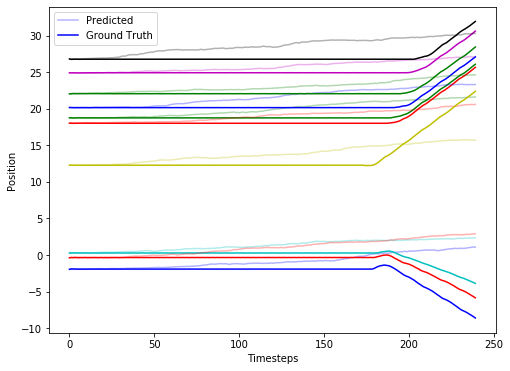

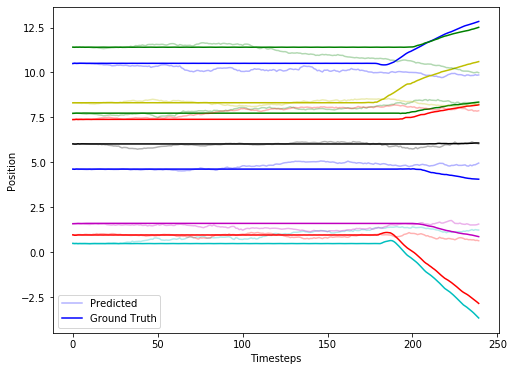

X RMSE:  1.9375199928908289
Y RMSE:  0.7632720881086791
(0.05, 0.05)


In [50]:
pf_model.dynamics_model.state_noise_stddev = (0.05, 0.05)
pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise_stddev)

### Model without end-to-end training

In [ ]:
pf_model.dynamics_model.state_noise = (0.005, 0.005)


# Back up model
buddy.save_checkpoint()

# Load the pre-end-to-end-training version of the model & evaluate
buddy.load_checkpoint(label="before_e2e_training")

pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)

# Restore model
buddy.load_checkpoint()